In [1]:
import pandas as pd
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt
sns.set()

pd.set_option('display.max_columns', 500)

In [2]:
def get_best_results(metrics):
    model_params = [col for col in metrics.columns if 'model_params' in col or 'selection_params' in col ]

    groupby_cols = ['dataset', 'selection_name', 'model_name', *model_params]
    grouped = metrics.groupby(groupby_cols, dropna=False)[["rmse_valid"]].mean()

    total_metrics_indexed = metrics.set_index(groupby_cols)

    best_results = total_metrics_indexed.loc[grouped.groupby(['dataset', 'selection_name', 'model_name'], dropna=False).rmse_valid.idxmin(), ['rmse', 'mae', 'mse', 'dataset_params_test_year', 'dataset_params_seq_len', 'dataset_params_crossval', "dataset_params_shift","dataset_params_pred_len",  'selected_features', 'duration', 'n_features']].reset_index()

    return best_results


In [61]:
total_metrics = pd.read_csv("results/ResSelNet/results_pollution_expanding_window.csv")

total_metrics["n_features"] = total_metrics.selected_features.str.replace("' '", "','", regex=True).apply(eval).apply(len)

In [62]:
total_metrics['model_name'] = total_metrics['model_name'].replace({'decisiontree': 'DT', 'lstm': "LSTM"})
total_metrics['selection_name'] = total_metrics['selection_name'].replace({'NoSelection': 'NS', 'TimeSelectionLayer': 'TSL', 'TimeSelectionLayerResidual': 'TSL'})

total_metrics.loc[(total_metrics.selection_name=='TSL') & (total_metrics.model_name=='LSTM')  & (total_metrics.selection_params_residual), 'model_name'] = 'TLSTMRes'
total_metrics.loc[(total_metrics.selection_name=='TSL') & (total_metrics.model_name=='LSTM')& (~total_metrics.selection_params_residual.fillna(False)), 'model_name'] = 'TLSTM'
total_metrics.loc[(total_metrics.selection_name=='TSL') & (total_metrics.model_name=='dense')& (total_metrics.selection_params_residual), 'model_name'] = 'TFFRes'
total_metrics.loc[(total_metrics.selection_name=='TSL') & (total_metrics.model_name=='dense')& (~total_metrics.selection_params_residual.fillna(False)), 'model_name'] = 'TFF'

total_metrics['model_name'] = total_metrics['model_name'].replace({'dense': 'FF', 'lasso': 'L1'})
total_metrics['dataset'] = total_metrics['dataset_name'].apply(lambda x: x.capitalize()).replace({'Rondadelvalle': 'Ronda del valle'})
total_metrics.drop("dataset_name", inplace=True, axis=1)

In [5]:
best_results = get_best_results(total_metrics)
best_results.groupby(['dataset', 'model_name'], dropna=False)[["rmse", "mse", "mae", "duration", 'n_features', 'dataset_params_seq_len']].mean().reset_index().pivot(index = 'dataset', columns='model_name', values=['mae', 'mse', 'rmse', 'dataset_params_seq_len']).round(1)#[["TFF", "TLSTM"]]#.to_latex()

mae                                                  mse  \
model_name           DT    FF    L1  LSTM   TFF TFFRes TLSTM TLSTMRes     DT   
dataset                                                                        
Aljarafe0523       12.6  12.2  11.8  12.0  11.8   11.7  11.9     11.6  260.3   
Asomadilla0523     12.3  12.0  11.4  11.5  11.3   11.1  11.4     11.2  247.8   
Bermejales0523     13.9  14.2  13.1  13.3  13.2   13.3  13.5     13.0  316.4   
Rondadelvalle0523  14.1  14.0  13.2  13.4  13.6   13.2  13.2     13.1  335.0   
Torneo0523         12.1  11.8  11.5  11.6  11.4    NaN  11.7      NaN  241.1   

                                                                      rmse  \
model_name            FF     L1   LSTM    TFF TFFRes  TLSTM TLSTMRes    DT   
dataset                                                                      
Aljarafe0523       244.5  229.6  237.6  229.1  228.8  232.2    225.9  16.1   
Asomadilla0523     233.8  218.4  220.1  215.5  214.1  219.4    213.4  15.7   
Bermejales0523     323.1  282.6  288.9  288.7  299.2  292.9    279.8  17.8   
Rondadelvalle0523  321.7  291.3  304.4  304.4  297.4  295.8    299.7  18.3   
Torneo0523         228.1  210.8  222.0  212.0    NaN  222.8      NaN  15.5   

                                                                 \
model_name           FF    L1  LSTM   TFF TFFRes TLSTM TLSTMRes   
dataset                                                           
Aljarafe0523       15.6  15.1  15.4  15.1   15.1  15.2     15.0   
Asomadilla0523     15.3  14.8  14.8  14.7   14.6  14.8     14.6   
Bermejales0523     18.0  16.8  17.0  17.0   17.2  17.1     16.7   
Rondadelvalle0523  17.9  17.0  17.4  17.4   17.2  17.2     17.3   
Torneo0523         15.1  14.5  14.9  14.6    NaN  14.9      NaN   

                  dataset_params_seq_len                                       \
model_name                            DT    FF    L1  LSTM   TFF TFFRes TLSTM   
dataset                                                                         
Aljarafe0523                        45.0  39.0  60.0  50.0  29.0   65.0  65.0   
Asomadilla0523                      34.5  39.0  56.0  50.0  29.0   28.0  28.0   
Bermejales0523                      45.0  24.0  56.0  50.0  29.0   53.0  51.0   
Rondadelvalle0523                   45.0  24.0  56.0  50.0  28.0   53.0  29.0   
Torneo0523                          34.5  52.0  25.0  50.0  49.0    NaN  28.0   

                            
model_name        TLSTMRes  
dataset                     
Aljarafe0523          51.0  
Asomadilla0523        51.0  
Bermejales0523        51.0  
Rondadelvalle0523     28.0  
Torneo0523             NaN

In [6]:
best_results.groupby(['dataset', 'model_name', 'dataset_params_test_year'], dropna=False)[["rmse", "mse", "mae", "duration", 'n_features']].mean().reset_index().pivot(index = ['dataset_params_test_year'], columns=["dataset", 'model_name'], values=['rmse']).dropna().round(1)#[["TFF", "TLSTM"]]#.to_latex()

rmse                                       \
dataset                  Aljarafe0523                                        
model_name                         DT    FF    L1  LSTM   TFF TFFRes TLSTM   
dataset_params_test_year                                                     
2013                             16.5  15.2  15.4  15.2  15.0   15.4  15.0   
2014                             16.2  15.7  15.3  15.5  15.4   15.3  15.4   
2015                             17.2  17.1  16.5  17.0  16.6   16.2  16.1   
2016                             15.9  16.3  15.2  15.2  14.9   15.5  14.9   
2017                             16.0  16.7  15.4  15.5  16.2   15.6  15.8   
2018                             15.7  14.9  14.6  14.7  14.7   15.0  14.3   
2019                             15.6  15.0  14.6  14.9  14.4   15.1  14.4   
2020                             14.4  13.8  13.7  13.8  13.6   13.6  14.3   
2021                             14.4  13.6  13.5  13.9  13.2   12.9  14.9   
2022                             15.6  14.1  14.0  14.3  14.2   13.5  13.7   
2023                             16.6  15.9  16.0  16.2  15.5   15.7  15.1   

                                                                          \
dataset                           Asomadilla0523                           
model_name               TLSTMRes             DT    FF    L1  LSTM   TFF   
dataset_params_test_year                                                   
2013                         15.3           16.3  15.6  14.9  15.4  14.8   
2014                         15.2           16.3  16.8  15.8  15.6  15.3   
2015                         16.3           16.7  16.2  15.5  15.4  15.4   
2016                         15.1           15.7  15.6  15.0  14.7  14.8   
2017                         15.5           16.8  15.9  15.6  15.8  15.4   
2018                         14.5           15.8  15.4  14.9  14.6  14.9   
2019                         14.4           15.6  15.2  15.1  15.3  15.2   
2020                         13.5           15.3  14.0  13.8  14.3  13.7   
2021                         13.3           15.6  14.5  14.7  15.2  15.0   
2022                         13.9           14.4  14.2  13.2  13.1  13.1   
2023                         15.6           14.5  14.5  13.8  13.4  13.5   

                                                                           \
dataset                                        Bermejales0523               
model_name               TFFRes TLSTM TLSTMRes             DT    FF    L1   
dataset_params_test_year                                                    
2013                       15.5  16.2     14.7           18.7  18.1  17.8   
2014                       15.6  15.6     15.7           18.3  18.2  17.6   
2015                       15.2  15.5     15.3           17.8  17.8  17.0   
2016                       14.7  14.9     14.7           17.6  18.0  16.8   
2017                       15.2  15.2     15.6           19.1  19.2  17.4   
2018                       14.7  14.6     14.7           18.9  18.8  17.7   
2019                       15.3  15.0     15.1           18.2  17.8  17.6   
2020                       13.3  14.4     13.4           16.8  17.5  16.3   
2021                       14.5  14.4     14.6           16.8  17.7  16.5   
2022                       13.1  13.1     13.3           16.3  16.7  14.9   
2023                       13.5  13.7     13.4           15.3  15.9  13.5   

                                                                              \
dataset                                                    Rondadelvalle0523   
model_name                LSTM   TFF TFFRes TLSTM TLSTMRes                DT   
dataset_params_test_year                                                       
2013                      17.5  17.7   17.3  18.0     17.4              19.0   
2014                      17.4  17.1   17.6  17.3     16.8              19.2   
2015                      17.2  17.0   17.1  17.3     16.8              18.3   
2016 

<Figure size 2000x2000 with 0 Axes>

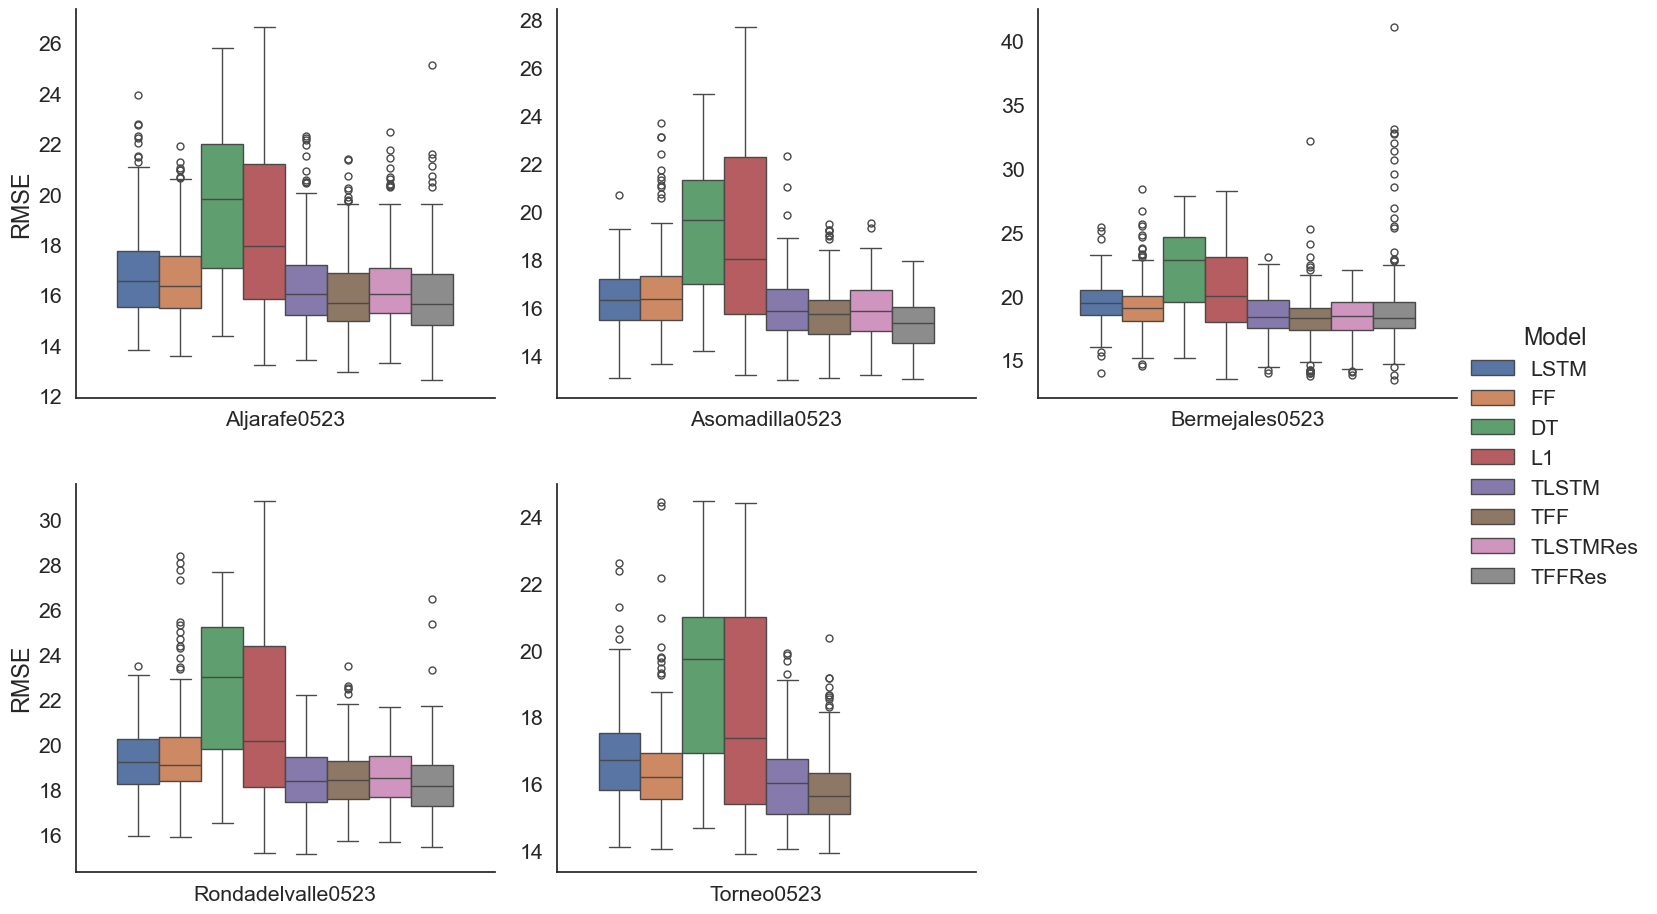

In [7]:
sns.set(font_scale=1.4, style='white')
plt.figure(figsize=(20,20))
#total_metrics.loc[:, 'selection_params_residual'] = total_metrics.loc[:, 'selection_params_residual'].fillna(False)
total_metrics_renamed = total_metrics.rename({'model_name': 'Model', 'rmse': 'RMSE', 'n_features': '# Features'}, axis=1)
g = sns.catplot(data=total_metrics_renamed, kind='box', x='dataset', y="RMSE", col='dataset', hue='Model', sharex=False, sharey=False, col_wrap=3, legend=True)#.set_yscale("log")
g.set(xlabel=None)
g.set_titles(template='')
plt.show()

<Figure size 2000x2000 with 0 Axes>

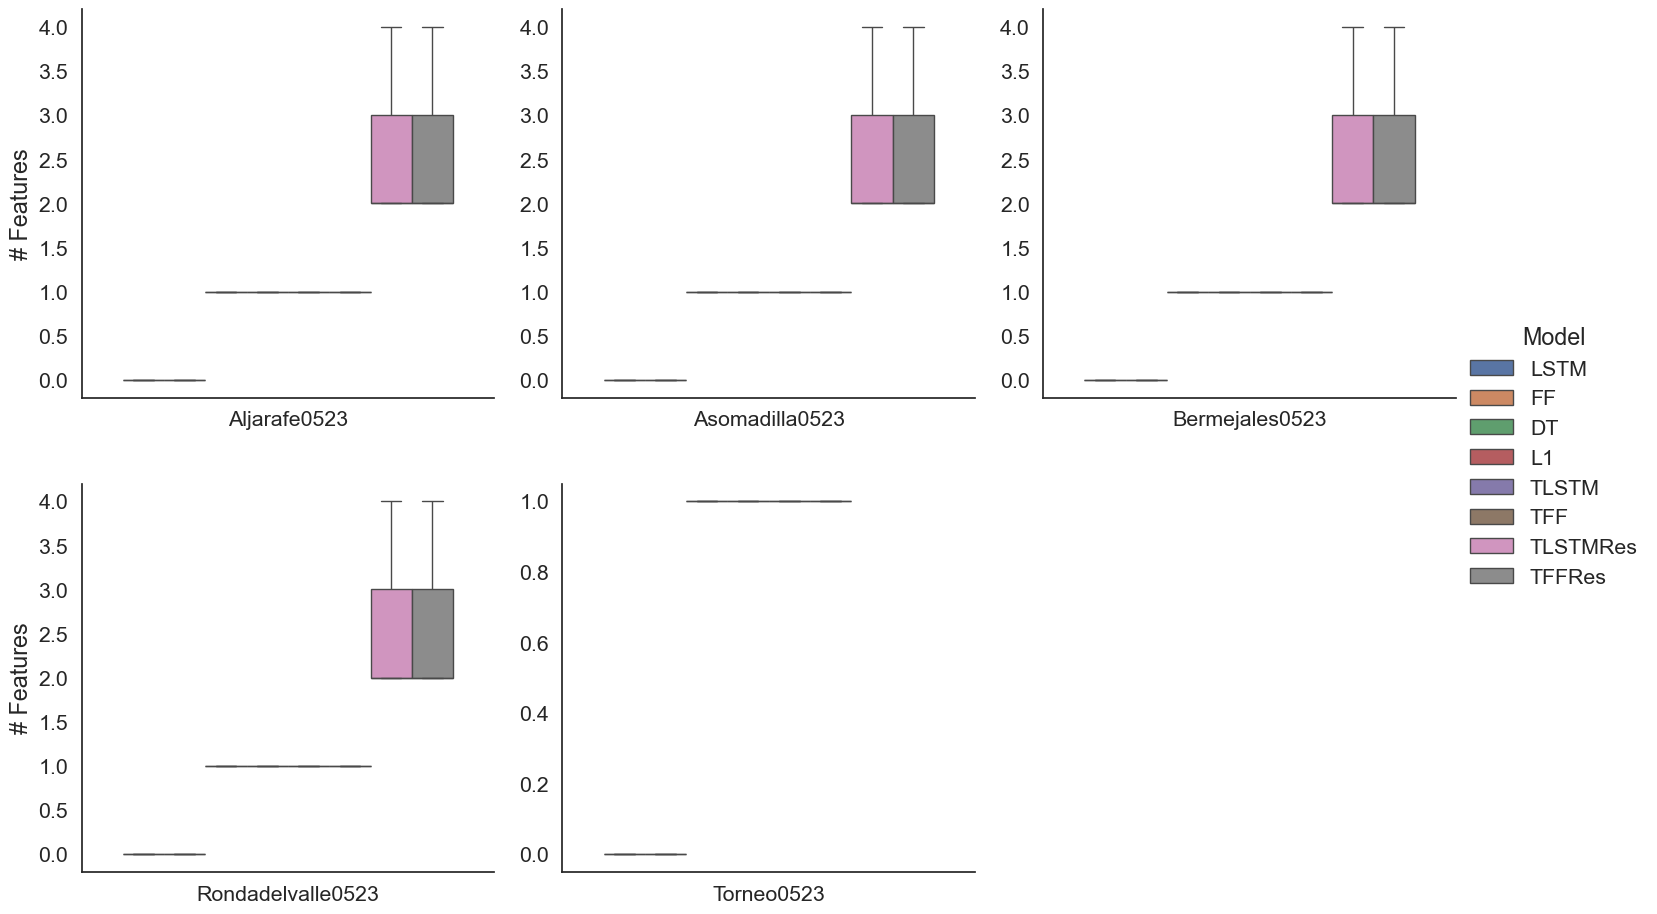

In [8]:
sns.set(font_scale=1.4, style='white')
plt.figure(figsize=(20,20))

g = sns.catplot(data=total_metrics_renamed, kind='box', x='dataset', y="# Features", col='dataset', hue='Model', sharex=False, sharey=False, col_wrap=3, legend=True)#.set_yscale("log")
g.set(xlabel=None)
g.set_titles(template='')
#plt.savefig('figures/boxplot_Features.png')
plt.show()
plt.show()

## Selection masks

C:\Users\User\AppData\Local\Temp\ipykernel_2952\3482180543.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_tsl_dataset_2023 = results_tsl_dataset[best_results['dataset_params_test_year']==2023]


1.2745098039215685


C:\Users\User\AppData\Local\Temp\ipykernel_2952\3482180543.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_tsl_dataset_2023 = results_tsl_dataset[best_results['dataset_params_test_year']==2023]


1.1503267973856208


C:\Users\User\AppData\Local\Temp\ipykernel_2952\3482180543.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_tsl_dataset_2023 = results_tsl_dataset[best_results['dataset_params_test_year']==2023]


1.2843137254901962


C:\Users\User\AppData\Local\Temp\ipykernel_2952\3482180543.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_tsl_dataset_2023 = results_tsl_dataset[best_results['dataset_params_test_year']==2023]


0.8809523809523809


C:\Users\User\AppData\Local\Temp\ipykernel_2952\3482180543.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_tsl_dataset_2023 = results_tsl_dataset[best_results['dataset_params_test_year']==2023]


IndexError: single positional indexer is out-of-bounds

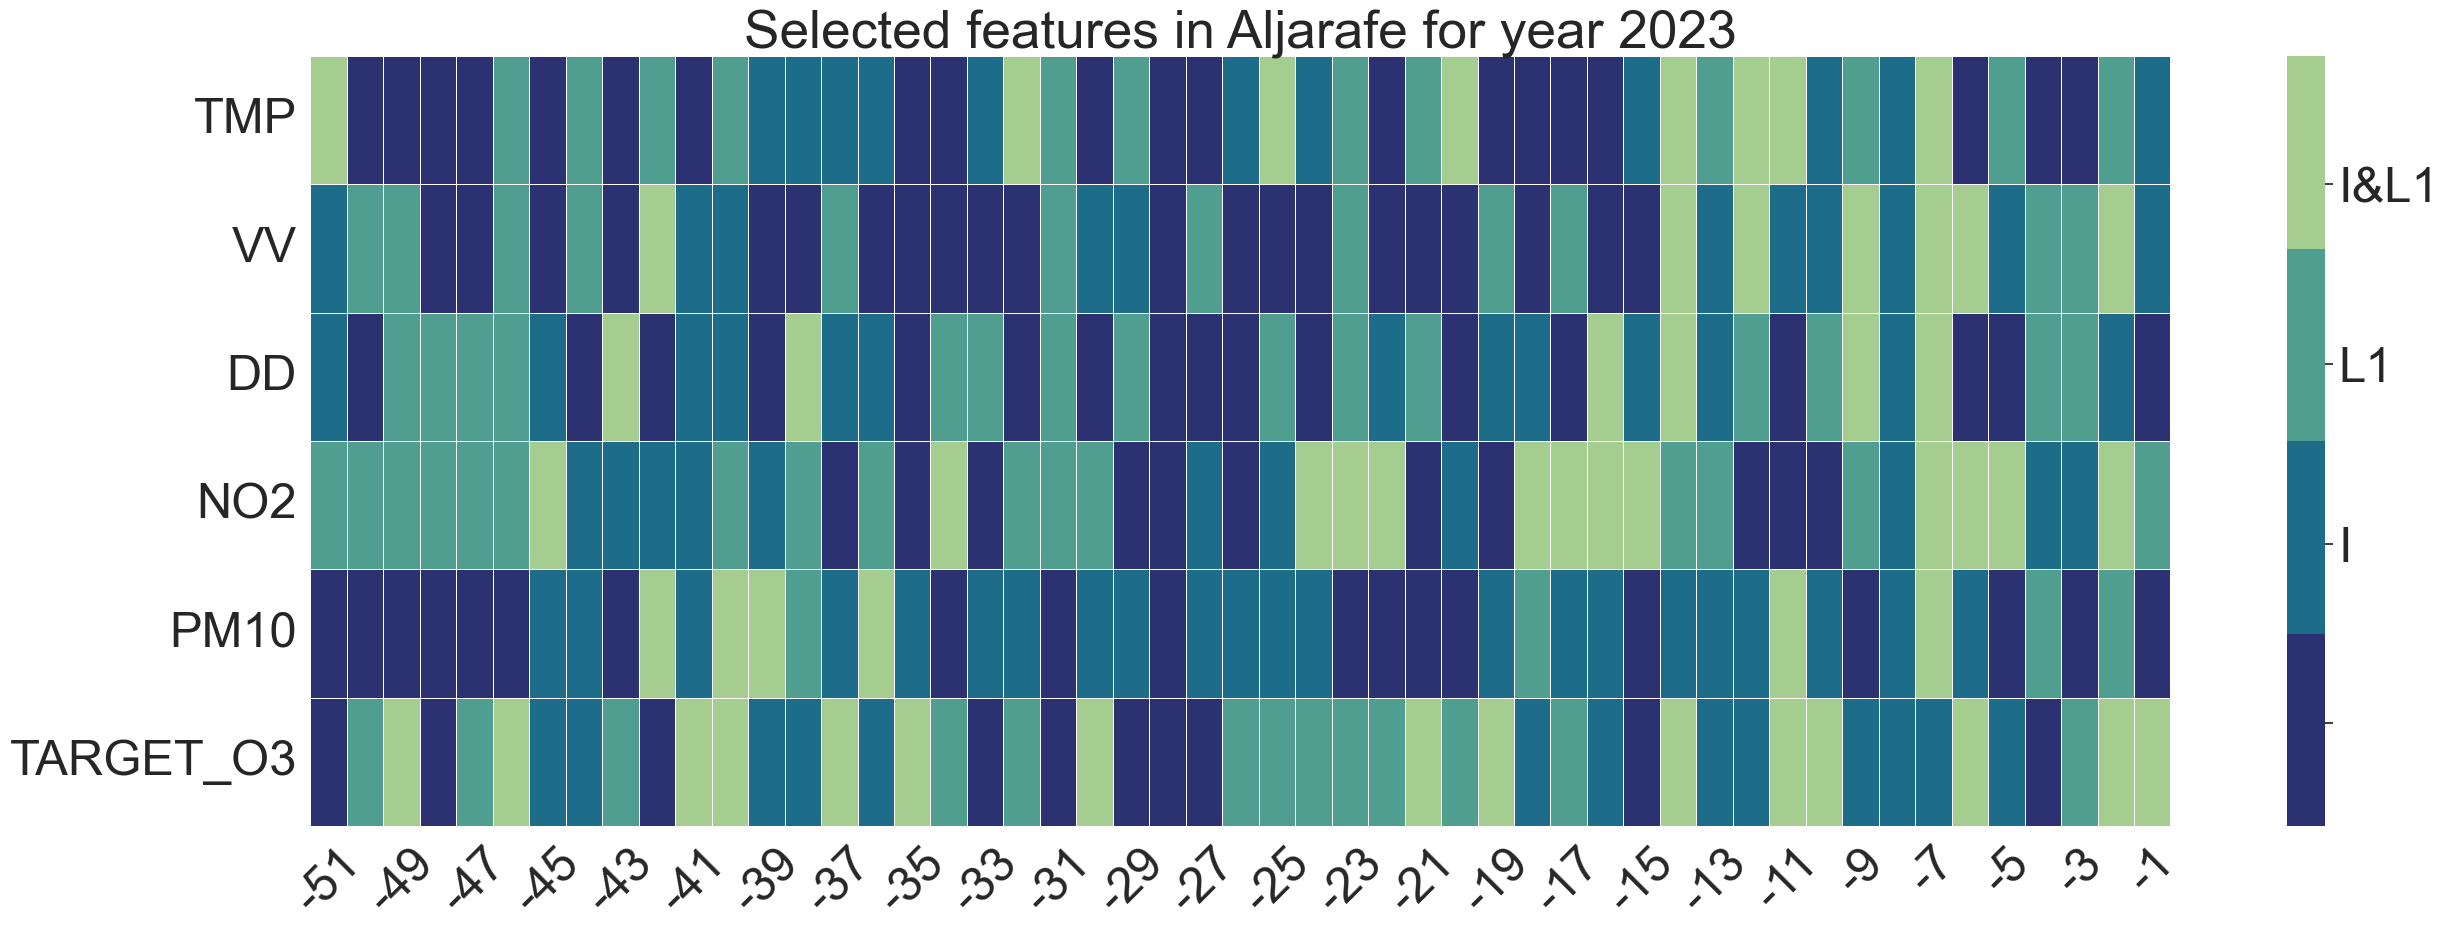

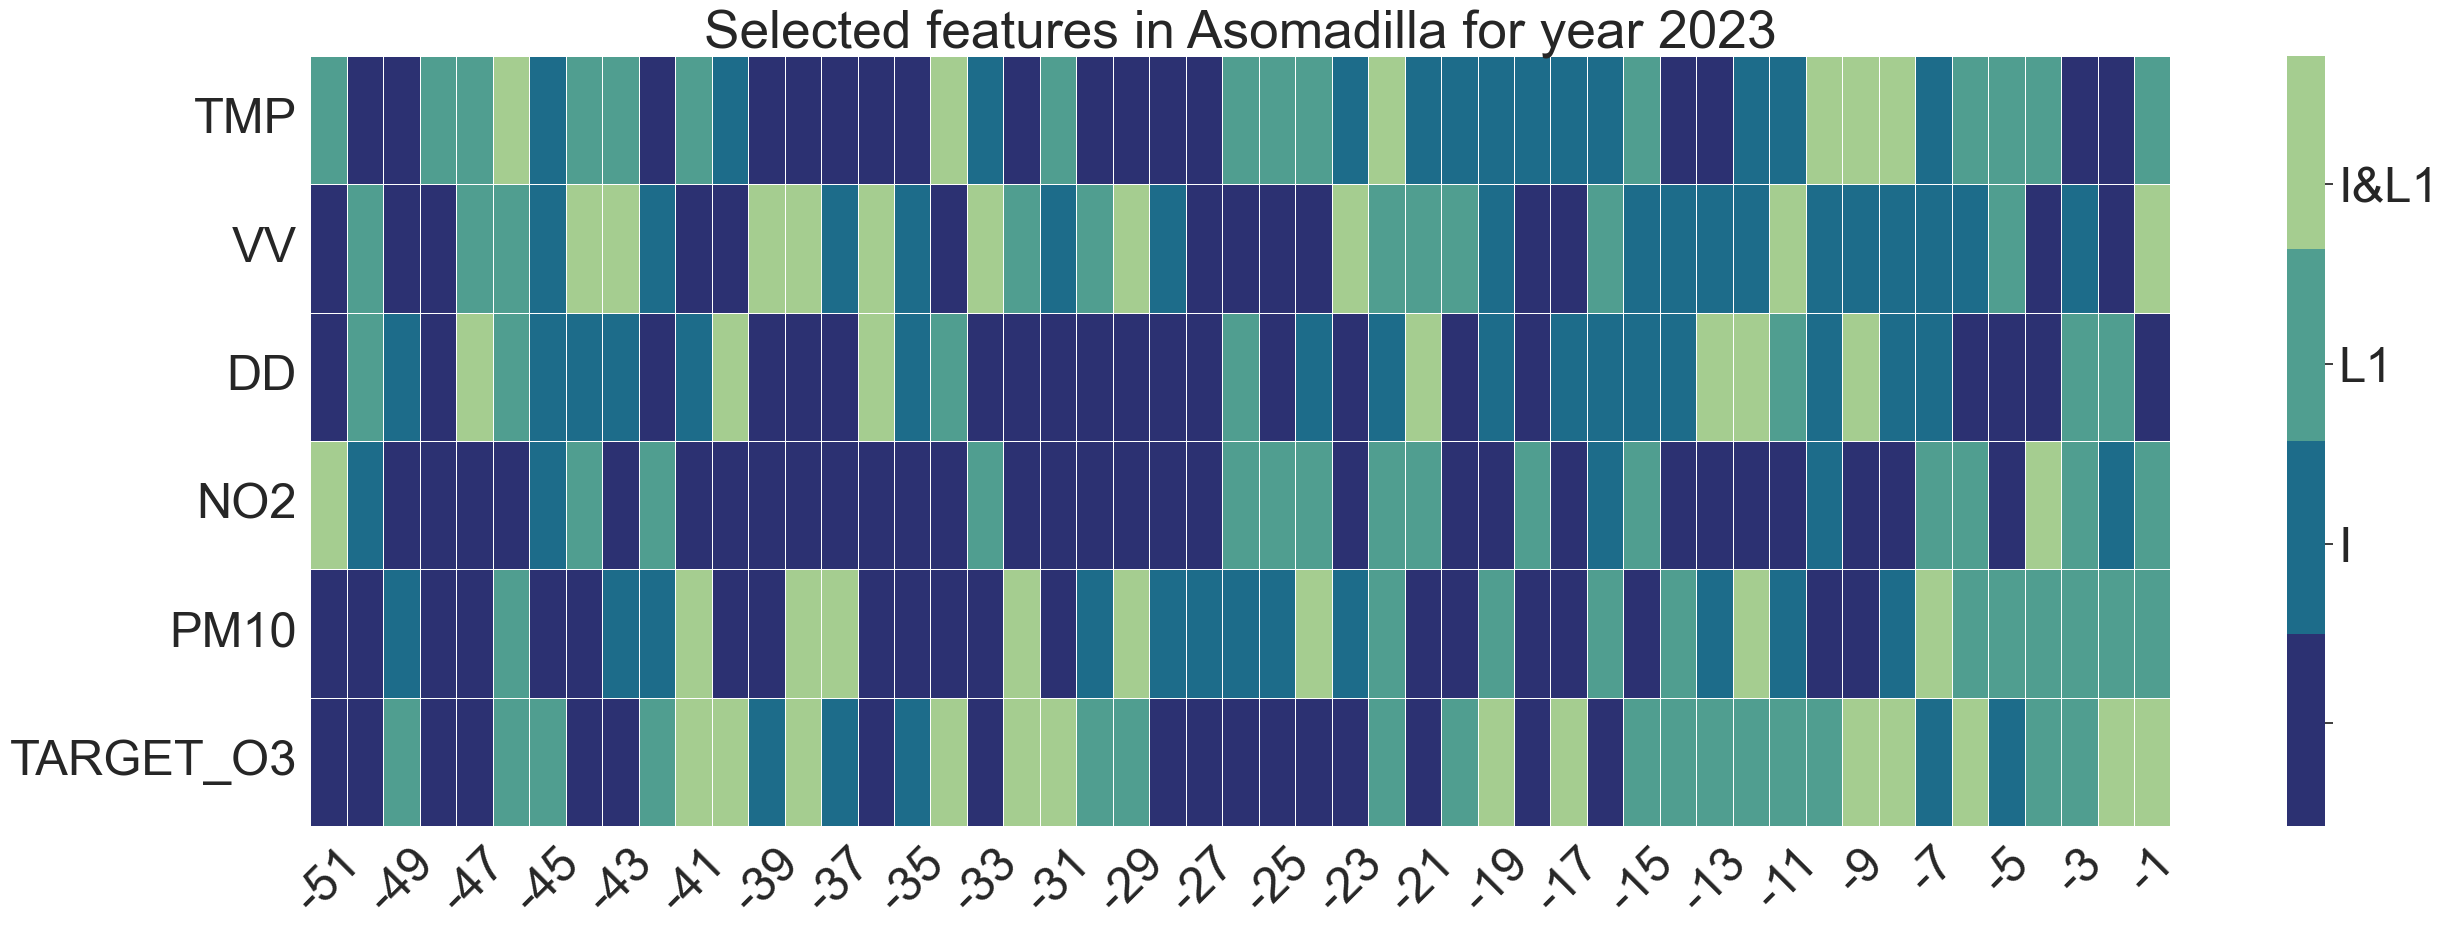

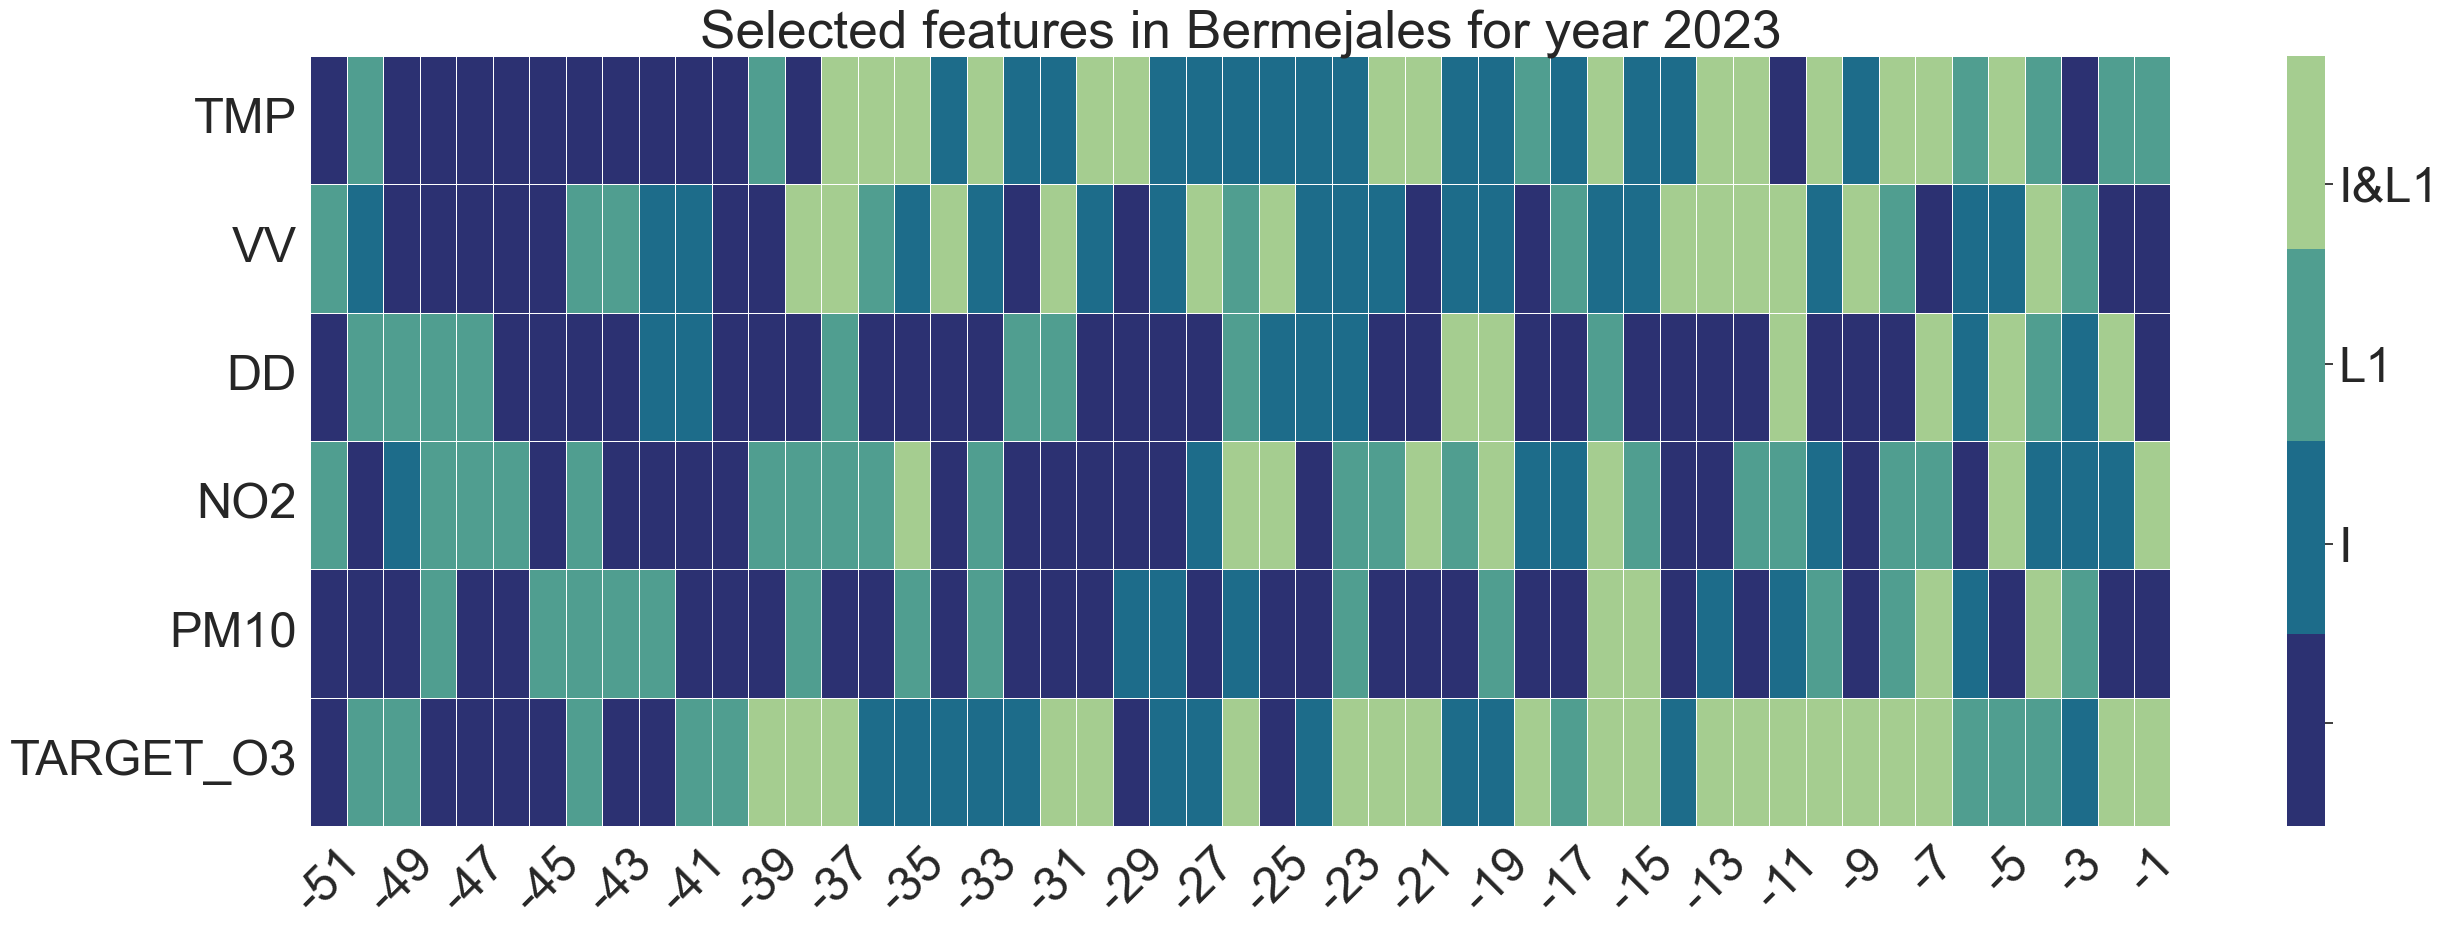

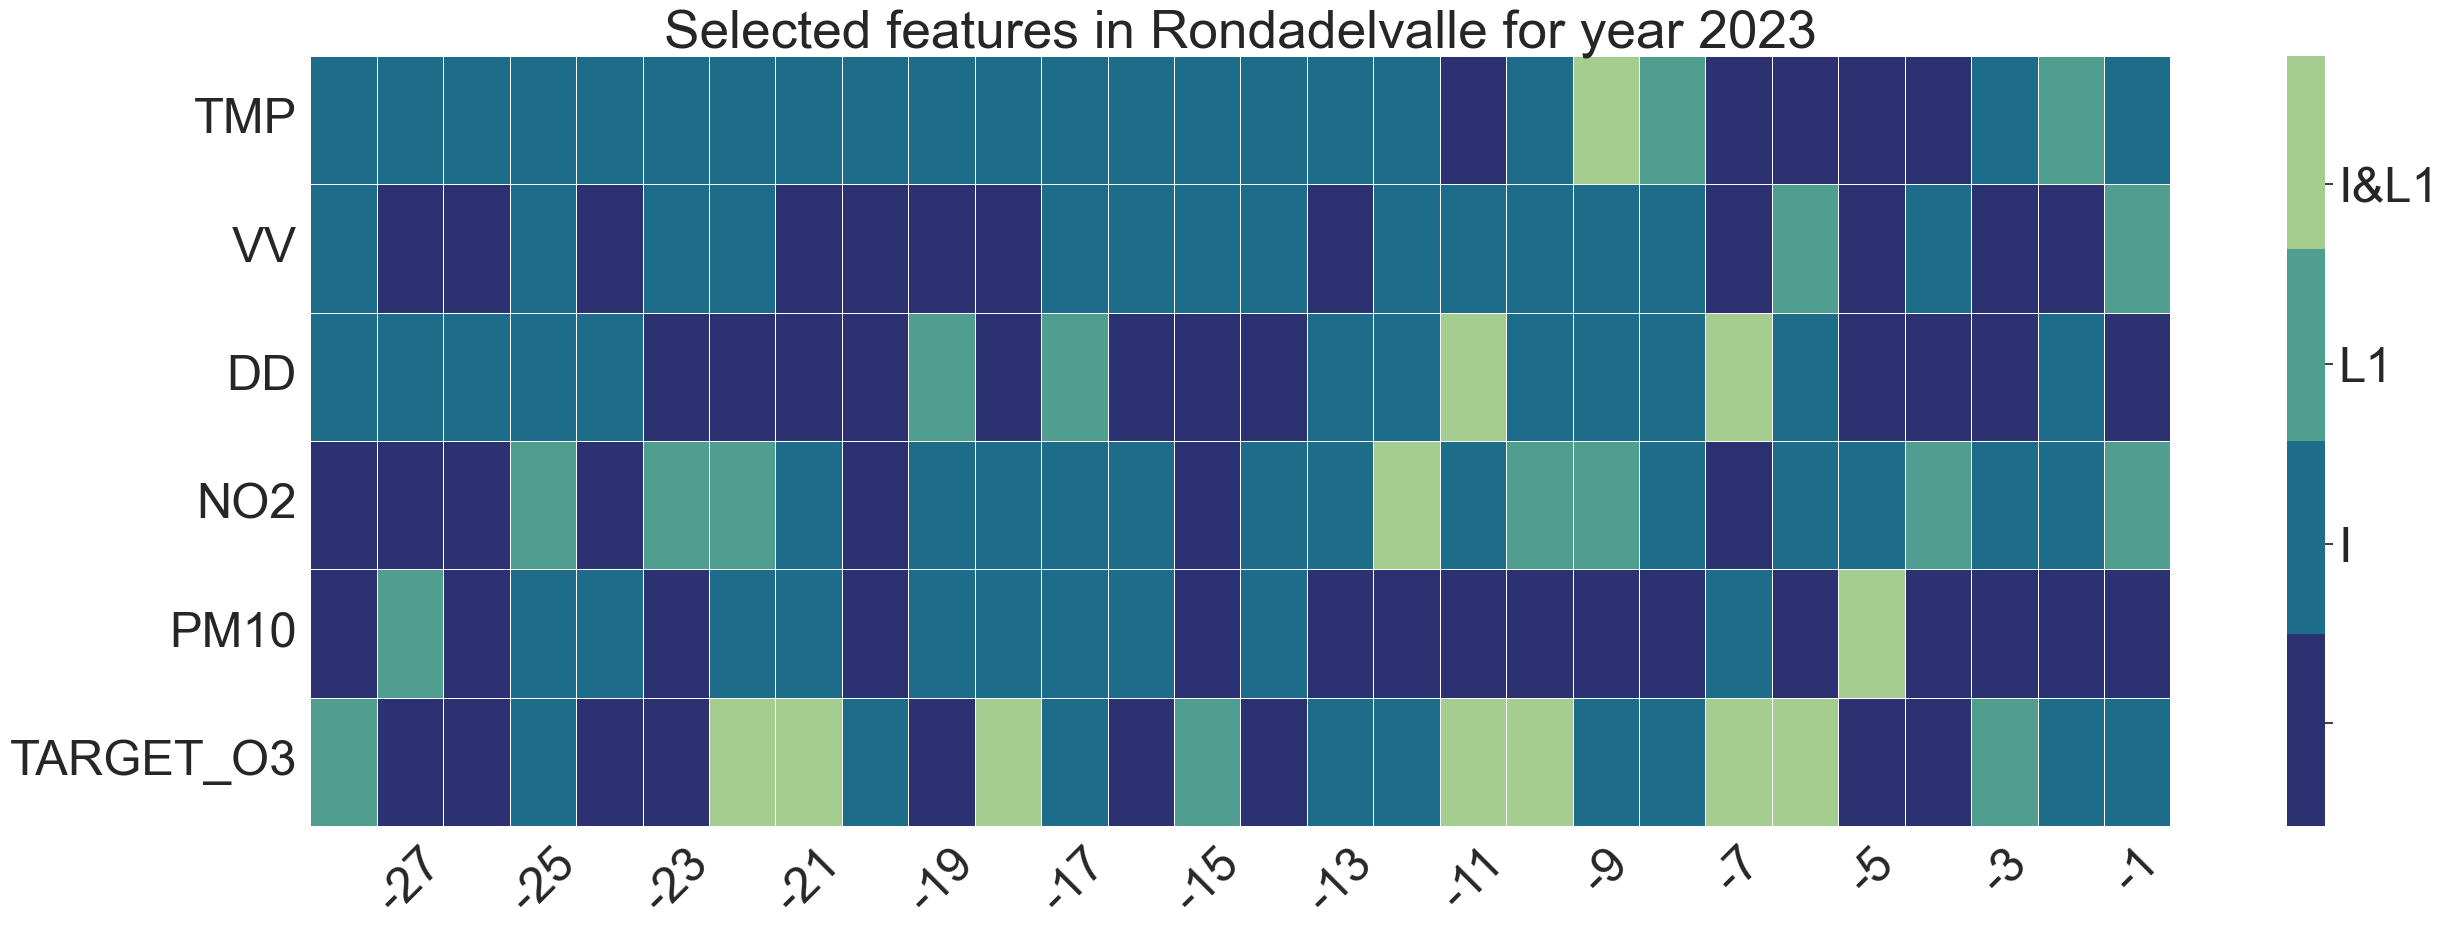

In [63]:
sns.set(font_scale=3.2)
import numpy as np
from matplotlib.colors import ListedColormap

model_name = 'TLSTMRes'

features_list = ['tmp', 'vv', 'dd', 'no2', 'pm10', 'target_o3']#['tmp', 'vv', 'dd', 'no2', 'pm10', 'o3']
for dataset in best_results.dataset.unique():
    results_tsl_dataset = best_results[(best_results.dataset==dataset) & (best_results.model_name==model_name)].sort_values('dataset_params_test_year')
    results_tsl_dataset_2023 = results_tsl_dataset[best_results['dataset_params_test_year']==2023]
    selected_features = results_tsl_dataset_2023.selected_features.apply(eval).iloc[0]

    selection_masks = []

    seq_lens = []
    for level, mask in selected_features.items():
        seq_lens.extend([int(name.split('t-')[1]) for name in mask])
    maximum_seq_len = max(seq_lens)

    level_score = [0, 1, 3]
    
    for feat in features_list:
        
        mask_by_level = np.zeros((maximum_seq_len,))
        for i, (level, mask) in enumerate(selected_features.items()):
            
            mask = np.array(mask)
            feats = np.array([f'{feat} t-{t}'for t in range (maximum_seq_len, 0, -1)])

            sfeats = mask[np.core.defchararray.find(mask, feat)!=-1]

            mask_selected = np.isin(feats, sfeats).astype(np.uint)
            mask_selected[mask_selected>0] += level_score[i]
            mask_by_level += mask_selected

        selection_masks.append(mask_by_level)
    
    selection_masks = np.stack(selection_masks)
    print(selection_masks.sum()/(selection_masks.shape[0]*selection_masks.shape[1]))
    fig, ax = plt.subplots(figsize=(30,10))

    ax.set_title(f'Selected features in {dataset[:-4]} for year 2023')

    number_of_levels = int(np.max(selection_masks))+1

    cmap_crest = sns.cm.crest_r
    cmap = ListedColormap(cmap_crest.colors[::(len(cmap_crest.colors)-1)//(number_of_levels-1)])
    feats[-2::-2] = ''
    g = sns.heatmap(selection_masks, yticklabels=list(map(lambda x: x.upper(), features_list)),cmap=cmap, xticklabels=list(map(lambda f: f.replace('target_o3 t', ''), feats.tolist())), linewidth=.5, ax=ax)
    plt.xticks(rotation=45)

    colorbar = g.collections[0].colorbar

    positions = np.array([0.4, 1.1, 1.8, 2.5, 3.2, 3.9, 4.6, 5.1, 5.8])
    levels = np.array(['', 'I', 'L1', "I&L1", "L2", "I&L2", "L1&L2", "I&L1&L2"])
    colorbar.set_ticks(positions[:number_of_levels])
    colorbar.set_ticklabels(levels[:number_of_levels])

    fig = g.get_figure()
    

    #fig.savefig(f"figures/SelectionMasks/Ozone_{dataset}.png", bbox_inches='tight') 
    

## Bayesian tests

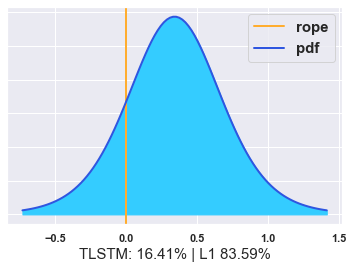

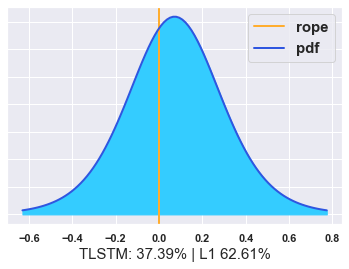

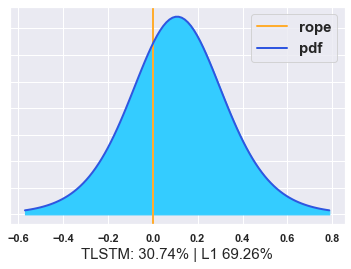

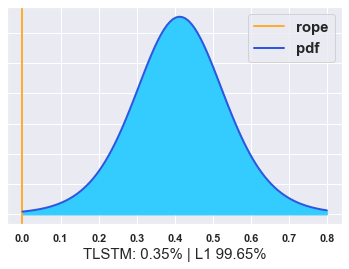

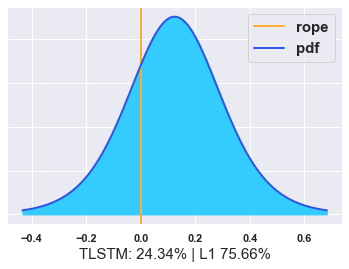

In [36]:
from baycomp import two_on_single
import matplotlib

import matplotlib.pyplot as plt



for dataset in best_metrics.dataset.unique():
    metrics_tsl = best_metrics[(best_metrics.dataset==dataset) & (best_metrics.model_name=='TLSTM')].root_mean_squared_error.values
    metrics_l1 = best_metrics[(best_metrics.dataset==dataset) & (best_metrics.model_name=='L1')].root_mean_squared_error.values
    probs, fig = two_on_single(metrics_tsl, metrics_l1, names=['TLSTM', 'L1'], plot=True)
    plt.xlabel(f'TLSTM: {round(probs[0]*100, 2)}% | L1 {round(probs[1]*100, 2)}%', fontsize=15)
    plt.legend(fontsize=15)
    fig.savefig(f"figures/Baytest/Baytest{dataset}.png") 

## Best hyperparameters

In [167]:
best_hyperparameters = best_by_year.reset_index().groupby(['dataset', 'model_name']).head(1).reset_index()

In [168]:
import numpy as np
pd.set_option('display.max_colwidth', 2000)
params = list(map(lambda my_dict: {k: my_dict[k] if not my_dict[k].is_integer() else int(my_dict[k]) for k in my_dict if not np.isnan(my_dict[k])},best_index.to_frame()[best_index.to_frame().model_name!='TSLRes'].loc[:, ['model_params_layers', 'model_params_units', 'model_params_batch_size', 'model_params_lr','model_params_dropout',  'model_params_max_depth', 'model_params_regularization','selection_params_regularization']].to_dict('records')))
best_hyperparameters['window'] = best_hyperparameters.dataset_params_seq_len #
best_hyperparameters['params'] = params

best_hyperparameters[["dataset", "model_name", "window", "params", "dataset_params_seq_len"]].set_index(['dataset', 'model_name', 'window'])#.iloc[-60:]#[best_hyperparameters.model_name=="TSL+LSTM"].set_index(['dataset']).to_dict('index')#.to_latex('tab.tex')

params  \
dataset        model_name window                                                                                                                                                                                                                                  
Aljarafe       DT         45                                                                                                                                                                                                      {'model_params_max_depth': 5}   
               FF         39                                                            {'model_params_layers': 1, 'model_params_units': 35, 'model_params_batch_size': 117, 'model_params_lr': 0.0062097346448451, 'model_params_dropout': 0.2868397433361429}   
               L1         38                                                                                                                                                                                {'model_params_regularization': 0.0001143748173448}   
               LSTM       68                                                             {'model_params_layers': 1, 'model_params_units': 24, 'model_params_batch_size': 31, 'model_params_lr': 0.0017370065514576, 'model_params_dropout': 0.4036956443547619}   
               TFF        41                                                                             {'model_params_layers': 2, 'model_params_units': 47, 'model_params_dropout': 0.163322450886048, 'selection_params_regularization': 0.0088594323988978}   
...                                                                                                                                                                                                                                                         ...   
Wikiwebtraffic LSTM       62                                                             {'model_params_layers': 2, 'model_params_units': 36, 'model_params_batch_size': 27, 'model_params_lr': 0.0042003747683163, 'model_params_dropout': 0.2070279939097841}   
               TFF        84       {'model_params_layers': 2, 'model_params_units': 45, 'model_params_batch_size': 80, 'model_params_lr': 0.0070276077642072, 'model_params_dropout': 0.073364287452905, 'selection_params_regularization': 0.0010234340548353}   
               TFFRes     70      {'model_params_layers': 2, 'model_params_units': 12, 'model_params_batch_size': 85, 'model_params_lr': 0.0069398794834175, 'model_params_dropout': 0.0079106214232781, 'selection_params_regularization': 0.0099732287722297}   
               TLSTM      70      {'model_params_layers': 2, 'model_params_units': 12, 'model_params_batch_size': 85, 'model_params_lr': 0.0069398794834175, 'model_params_dropout': 0.0079106214232781, 'selection_params_regularization': 0.0099732287722297}   
               TLSTMRes   82       {'model_params_layers': 1, 'model_params_units': 37, 'model_params_batch_size': 83, 'model_params_lr': 0.0098872999286832, 'model_params_dropout': 0.2844257185432406, 'selection_params_regularization': 0.005797494217936}   

                                  dataset_params_seq_len  
dataset        model_name window                          
Aljarafe       DT         45                          45  
               FF         39                          39  
               L1         38                          38  
               LSTM       68                          68  
               TFF        41                          41  
...                                                  ...  
Wikiwebtraffic LSTM       62                          62  
               TFF        84                          84  
               TFFRes     70                          70  
               TLSTM      70                          70  
               TLSTMRes   82                          82  

[128 rows x 2 columns]

In [170]:
best_hyperparameters.to_csv("results/ResSelNet/params/best_params.csv")